The goal of this notebook is to preprocess data and save it as `.png` files





Images - [Data source](https://ndownloader.figshare.com/files/14487263?private_link=d932c564d5cdd7186679)

Masks - [Data source](https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/14487260/FinalResults3DMMS.zip)

In [ ]:
!wget https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/14487263/RawMembraneImage.zip
!unzip /content/RawMembraneImage.zip
!wget https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/14487260/FinalResults3DMMS.zip
!unzip /content/FinalResults3DMMS.zip

In [ ]:
import scipy.io
import os
import matplotlib.pyplot as plt 
from IPython.display import clear_output
import numpy as np
import cv2
from tqdm.notebook import tqdm
import pandas as pd 
from PIL import Image

In [ ]:
all_paths =  os.listdir("/content/170704plc1p2/")
all_paths_np = np.array(all_paths)
bools_image_paths = [all_paths[i][0] == "m" for i in range(len(all_paths))]
bools_seg_paths = [all_paths[i][0] == "T" for i in range(len(all_paths))]
image_paths = all_paths_np[bools_image_paths]
seg_paths = all_paths_np[bools_seg_paths]
image_paths = all_paths_np[bools_image_paths]
seg_paths = all_paths_np[bools_seg_paths]

In [ ]:
def pair_memb_seg_lists(memb, seg):
    memb_fix, seg_fix=[],[]
    for i in memb:
        for j in seg:
            if i[5:8] == j[1:4]:
                memb_fix.append(i)
                seg_fix.append(j)
    return(memb_fix, seg_fix)

In [ ]:
images_fix, seg_fix = pair_memb_seg_lists(image_paths, seg_paths)
mat = scipy.io.loadmat("/content/170704plc1p2/" + images_fix[10])
seg_np = scipy.io.loadmat("/content/170704plc1p2/" + seg_fix[10])

image = (mat["embryo"])
segmented = seg_np["membSeg"]
segmented.shape,image.shape

((205, 285, 134), (256, 356, 70))

In [ ]:
def show_n_channel_image(n_channels, image):
    for i in range(n_channels):
        clear_output(wait=True)
        plt.imshow(image[:,:,i])
        plt.show()

show_n_channel_image(134, segmented)

In [ ]:
show_n_channel_image(70, image)

In [ ]:
seg_mv = np.moveaxis(segmented, 2,0)

def partition(lst, n):
    increment = len(lst) / float(n)
    last = 0
    i = 1
    results = []
    while last < len(lst):
        idx = int(round(increment * i))
        results.append(lst[last:idx])
        last = idx
        i += 1
    return results

slices = partition(seg_mv, 70)


In [ ]:
def show_images(img_list):
    len_x = len(img_list)
    fig, ax = plt.subplots(1,len_x, figsize = (10,3))
    for i in range(len(img_list)):
        ax[i].imshow(img_list[i])

In [ ]:
def prepare_segmentation_data(data_foldername = "170704plc1p2",  save_folder = "training_data_pil"):
    metadata = []
    
    if os.path.isdir(save_folder) is not True:
        os.mkdir(save_folder)
        os.mkdir(save_folder + "/" + "masks")
        os.mkdir(save_folder + "/" + "images")
        
        
    all_paths =  os.listdir(data_foldername)
    all_paths_np = np.array(all_paths)
    bools_image_paths = [all_paths[i][0] == "m" for i in range(len(all_paths))]
    bools_seg_paths = [all_paths[i][0] == "T" for i in range(len(all_paths))]
    image_paths = all_paths_np[bools_image_paths]
    seg_paths = all_paths_np[bools_seg_paths]
    images_fix, seg_fix = pair_memb_seg_lists(image_paths, seg_paths)

    
    for i in tqdm(range(len(images_fix))):
        img_mat = scipy.io.loadmat(data_foldername + "/" + images_fix[i])
        seg_mat = scipy.io.loadmat(data_foldername + "/" + seg_fix[i])

        images = mat["embryo"]
        segs = seg_mat["membSeg"]
        
        images_mv = np.moveaxis(images, 2,0)
        seg_mv = np.moveaxis(segmented, 2,0)
        
        slices = partition(seg_mv, 70)
        
        for j in range(9,58,1):  ## exclude black or mostly black images 
            image_name = "real_" + str(i)+"_"+str(j)+ ".png"

            image = images_mv[j]
            masks = slices[j]
            im = Image.fromarray(image)
            im.save(save_folder + "/images/" + image_name, 'PNG', quality=100)
            # plt.imshow(image)
            # plt.show()
#             print(save_folder + "/images/" + image_name)
            
            for k in range(len(masks)):
                mask_name = "mask_" + str(i) + "_" + str(j) + "_" + str(k) + ".png"
                #cv2.imwrite(save_folder + "/masks/" + mask_name, masks[k])
                msk = Image.fromarray(masks[k])
                # plt.imshow(masks[k])
                # plt.show()
                msk.save(save_folder + "/masks/" + mask_name, 'PNG', quality=100)
                metadata.append([save_folder + "/images/" + image_name, save_folder + "/masks/" + mask_name])
    return metadata

In [ ]:
metadata = prepare_segmentation_data(data_foldername = "170704plc1p2", save_folder = "training_data_pil")

In [ ]:
df = pd.DataFrame(metadata, columns = ["image", "mask"])
df.to_csv("metadata_pil.csv", index = False )
df.tail()

,image,mask
8925,training_data_pil/images/real_94_55.png,training_data_pil/masks/mask_94_55_1.png
8926,training_data_pil/images/real_94_56.png,training_data_pil/masks/mask_94_56_0.png
8927,training_data_pil/images/real_94_56.png,training_data_pil/masks/mask_94_56_1.png
8928,training_data_pil/images/real_94_57.png,training_data_pil/masks/mask_94_57_0.png
8929,training_data_pil/images/real_94_57.png,training_data_pil/masks/mask_94_57_1.png


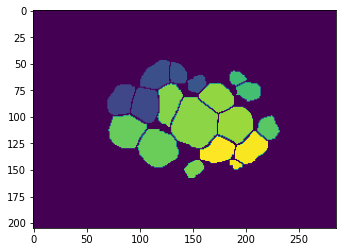

In [ ]:
plt.imshow(plt.imread('training_data_pil/masks/mask_94_57_0.png'))

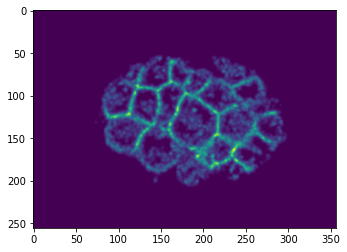

In [ ]:
plt.imshow(plt.imread('training_data_pil/images/real_94_57.png'))

In [ ]:
!rm -rf training_data_pil.zip
!zip -r training_data_pil.zip training_data_pil/

In [ ]:
!cp -r /content/training_data_pil.zip /content/drive/MyDrive/mydata/3d_seg_data/

In [ ]:
!cp -r /content/metadata_pil.csv /content/drive/MyDrive/mydata/3d_seg_data/